In [1]:
# Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

print(" Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

 Libraries imported successfully!
TensorFlow version: 2.20.0


In [2]:
# Cell 2: Load and Explore Dataset
print(" LOADING AND EXPLORING DATASET")
print("="*50)

# Load the dataset
match_data = pd.read_csv('match_winner_data.csv')

# Basic dataset information
print("Dataset Shape:", match_data.shape)
print("\nDataset Columns:")
print(match_data.columns.tolist())
print("\nFirst 5 rows:")
print(match_data.head())

print("\nDataset Info:")
print(match_data.info())

 LOADING AND EXPLORING DATASET
Dataset Shape: (6840, 40)

Dataset Columns:
['Unnamed: 0', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts']

First 5 rows:
   Unnamed: 0      Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTGS  ATGS  \
0           0  19/08/00  Charlton       Man City     4     0   H     0     0   
1           1  19/08/00   Chelsea       West Ham     4     2   H     0     0   
2           2  19/08/00  Coventry  Middlesbrough     1     3  NH     0     0   
3           3  19/08/00     Derby    Southampton     2     2  NH     0     0   
4           4  19/08/00     Leeds        Everton     2     0   H     0     0   

   HT

 ANALYZING TARGET VARIABLE DISTRIBUTION
Match Result Distribution:
NH: 3664 matches (53.6%)
H: 3176 matches (46.4%)

Home Win Rate: 46.4%
Not Home Win Rate: 53.6%


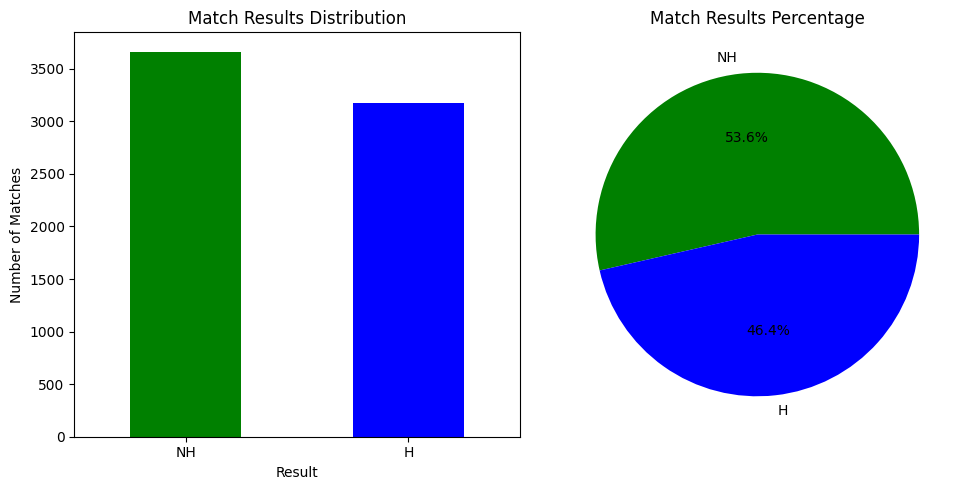

In [4]:
# Cell 3: Understand Target Variable Distribution
print(" ANALYZING TARGET VARIABLE DISTRIBUTION")
print("="*50)

# Check the distribution of match results
match_result_counts = match_data['FTR'].value_counts()
match_result_percentages = match_data['FTR'].value_counts(normalize=True) * 100

print("Match Result Distribution:")
for result, count in match_result_counts.items():
    percentage = match_result_percentages[result]
    print(f"{result}: {count} matches ({percentage:.1f}%)")

# Create binary target for Home Win vs Not Home Win
match_data['is_home_win'] = match_data['FTR'].apply(lambda x: 1 if x == 'H' else 0)
home_win_percentage = match_data['is_home_win'].mean() * 100

print(f"\nHome Win Rate: {home_win_percentage:.1f}%")
print(f"Not Home Win Rate: {100 - home_win_percentage:.1f}%")

# Visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
match_result_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Match Results Distribution')
plt.xlabel('Result')
plt.ylabel('Number of Matches')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(match_result_counts.values, labels=match_result_counts.index, 
        autopct='%1.1f%%', colors=['green', 'blue', 'red'])
plt.title('Match Results Percentage')

plt.tight_layout()
plt.show()

In [5]:
# Cell 4: Define Key Features for Prediction
print(" SELECTING PREDICTION FEATURES")
print("="*50)

# Team performance streak features
team_streak_features = [
    'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5',
    'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5'
]

# Team form and performance metrics
team_performance_features = [
    'HTP', 'ATP',           # Team performance points
    'HTFormPts', 'ATFormPts', # Recent form points
    'HTGD', 'ATGD',          # Goal difference
    'DiffPts', 'DiffFormPts' # Difference between teams
]

# Combine all features
selected_prediction_features = team_streak_features + team_performance_features

print("Selected Features for Prediction:")
for i, feature in enumerate(selected_prediction_features, 1):
    print(f"{i:2d}. {feature}")

print(f"\nTotal features selected: {len(selected_prediction_features)}")

 SELECTING PREDICTION FEATURES
Selected Features for Prediction:
 1. HTWinStreak3
 2. HTWinStreak5
 3. HTLossStreak3
 4. HTLossStreak5
 5. ATWinStreak3
 6. ATWinStreak5
 7. ATLossStreak3
 8. ATLossStreak5
 9. HTP
10. ATP
11. HTFormPts
12. ATFormPts
13. HTGD
14. ATGD
15. DiffPts
16. DiffFormPts

Total features selected: 16


In [6]:
# Cell 5: Data Quality Check and Cleaning
print(" DATA QUALITY CHECK AND CLEANING")
print("="*50)

# Check for missing values in selected features
missing_data = match_data[selected_prediction_features + ['is_home_win']].isnull().sum()
missing_percentage = (missing_data / len(match_data)) * 100

print("Missing Values Analysis:")
for feature in missing_data.index:
    if missing_data[feature] > 0:
        print(f"  {feature}: {missing_data[feature]} missing ({missing_percentage[feature]:.1f}%)")

# Remove rows with missing values in our selected features
clean_match_data = match_data.dropna(subset=selected_prediction_features + ['is_home_win'])

print(f"\nOriginal dataset size: {len(match_data)}")
print(f"Clean dataset size: {len(clean_match_data)}")
print(f"Rows removed: {len(match_data) - len(clean_match_data)}")

# Check the distribution after cleaning
clean_home_win_rate = clean_match_data['is_home_win'].mean() * 100
print(f"\nHome Win Rate in clean data: {clean_home_win_rate:.1f}%")

 DATA QUALITY CHECK AND CLEANING
Missing Values Analysis:

Original dataset size: 6840
Clean dataset size: 6840
Rows removed: 0

Home Win Rate in clean data: 46.4%


 EXPLORATORY DATA ANALYSIS
Feature Statistics:
       HTWinStreak3  HTWinStreak5  HTLossStreak3  HTLossStreak5  ATWinStreak3  \
count   6840.000000   6840.000000    6840.000000    6840.000000   6840.000000   
mean       0.062281      0.017982       0.057602       0.014327      0.062865   
std        0.241682      0.132897       0.233007       0.118846      0.242739   
min        0.000000      0.000000       0.000000       0.000000      0.000000   
25%        0.000000      0.000000       0.000000       0.000000      0.000000   
50%        0.000000      0.000000       0.000000       0.000000      0.000000   
75%        0.000000      0.000000       0.000000       0.000000      0.000000   
max        1.000000      1.000000       1.000000       1.000000      1.000000   

       ATWinStreak5  ATLossStreak3  ATLossStreak5          HTP          ATP  \
count   6840.000000    6840.000000    6840.000000  6840.000000  6840.000000   
mean       0.016520       0.051023       0.010234     1.209014   

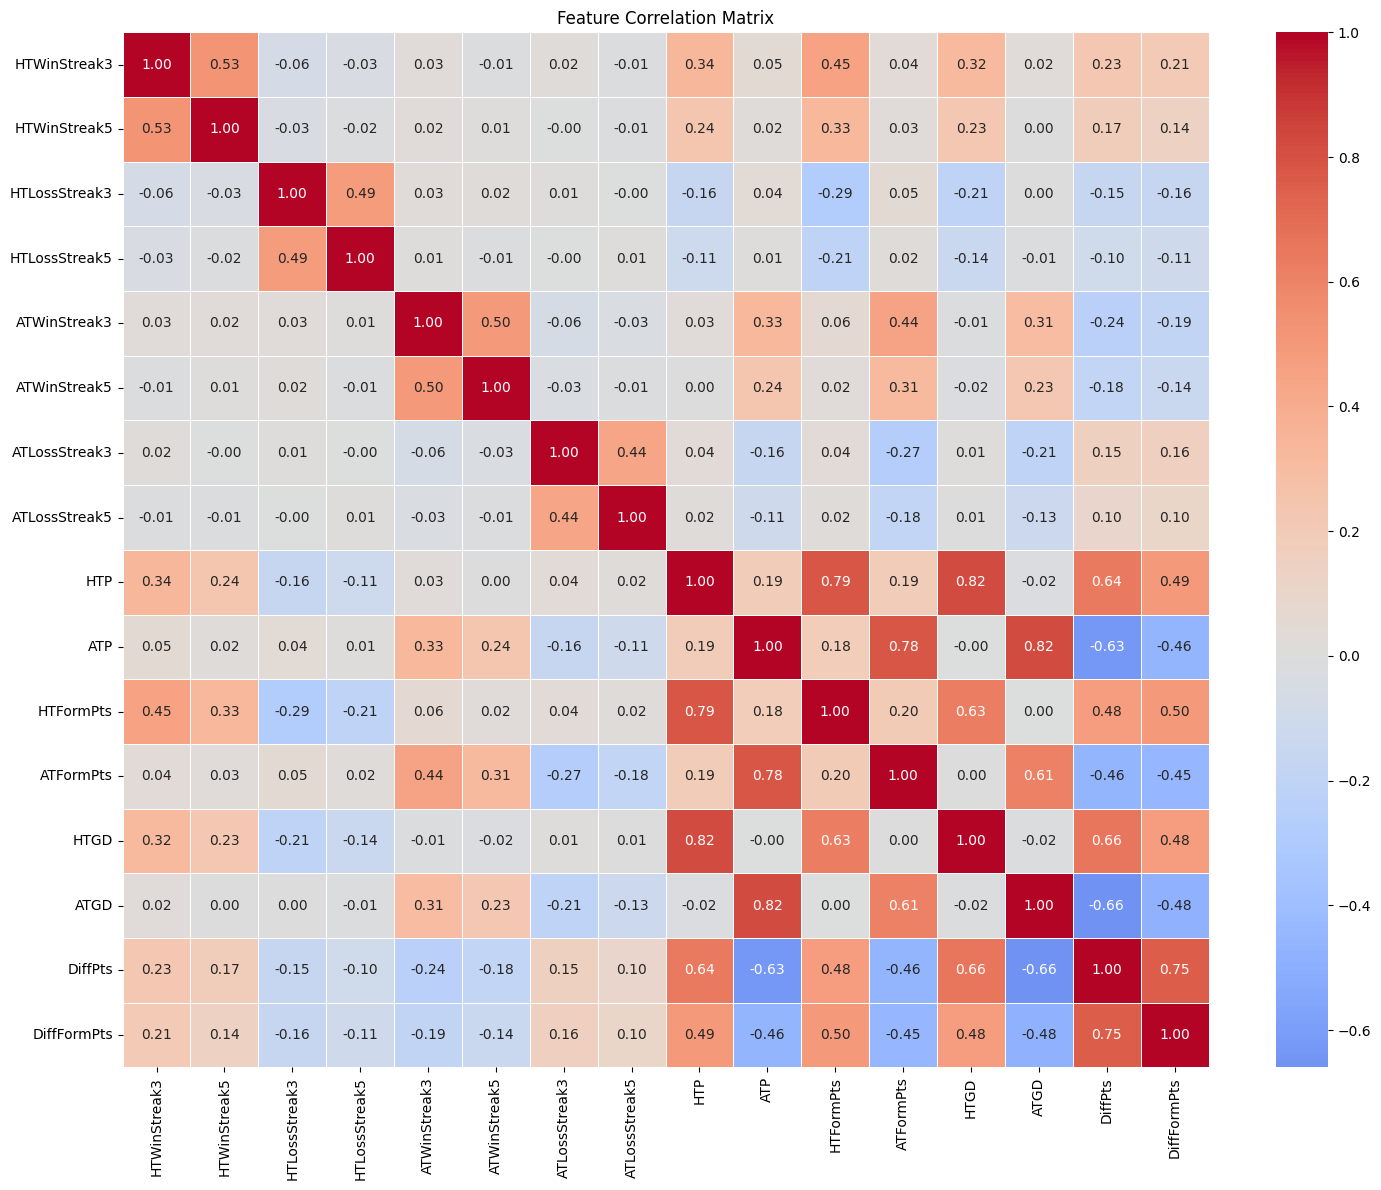


Top 10 Features Correlated with Home Wins:
  DiffPts: 0.302
  HTGD: 0.227
  ATGD: -0.216
  HTP: 0.202
  DiffFormPts: 0.197
  ATP: -0.181
  HTFormPts: 0.170
  ATFormPts: -0.153
  HTWinStreak3: 0.080
  ATWinStreak3: -0.074


In [7]:
# Cell 6: Exploratory Data Analysis (EDA)
print(" EXPLORATORY DATA ANALYSIS")
print("="*50)

# Create feature matrix and target
feature_matrix = clean_match_data[selected_prediction_features]
target_vector = clean_match_data['is_home_win']

print("Feature Statistics:")
print(feature_matrix.describe())

# Correlation analysis
plt.figure(figsize=(15, 12))
correlation_matrix = feature_matrix.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Analyze top correlated features with target
target_correlations = []
for feature in selected_prediction_features:
    correlation = feature_matrix[feature].corr(target_vector)
    target_correlations.append((feature, correlation))

target_correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print("\nTop 10 Features Correlated with Home Wins:")
for feature, corr in target_correlations[:10]:
    print(f"  {feature}: {corr:.3f}")

 FEATURE DISTRIBUTION ANALYSIS


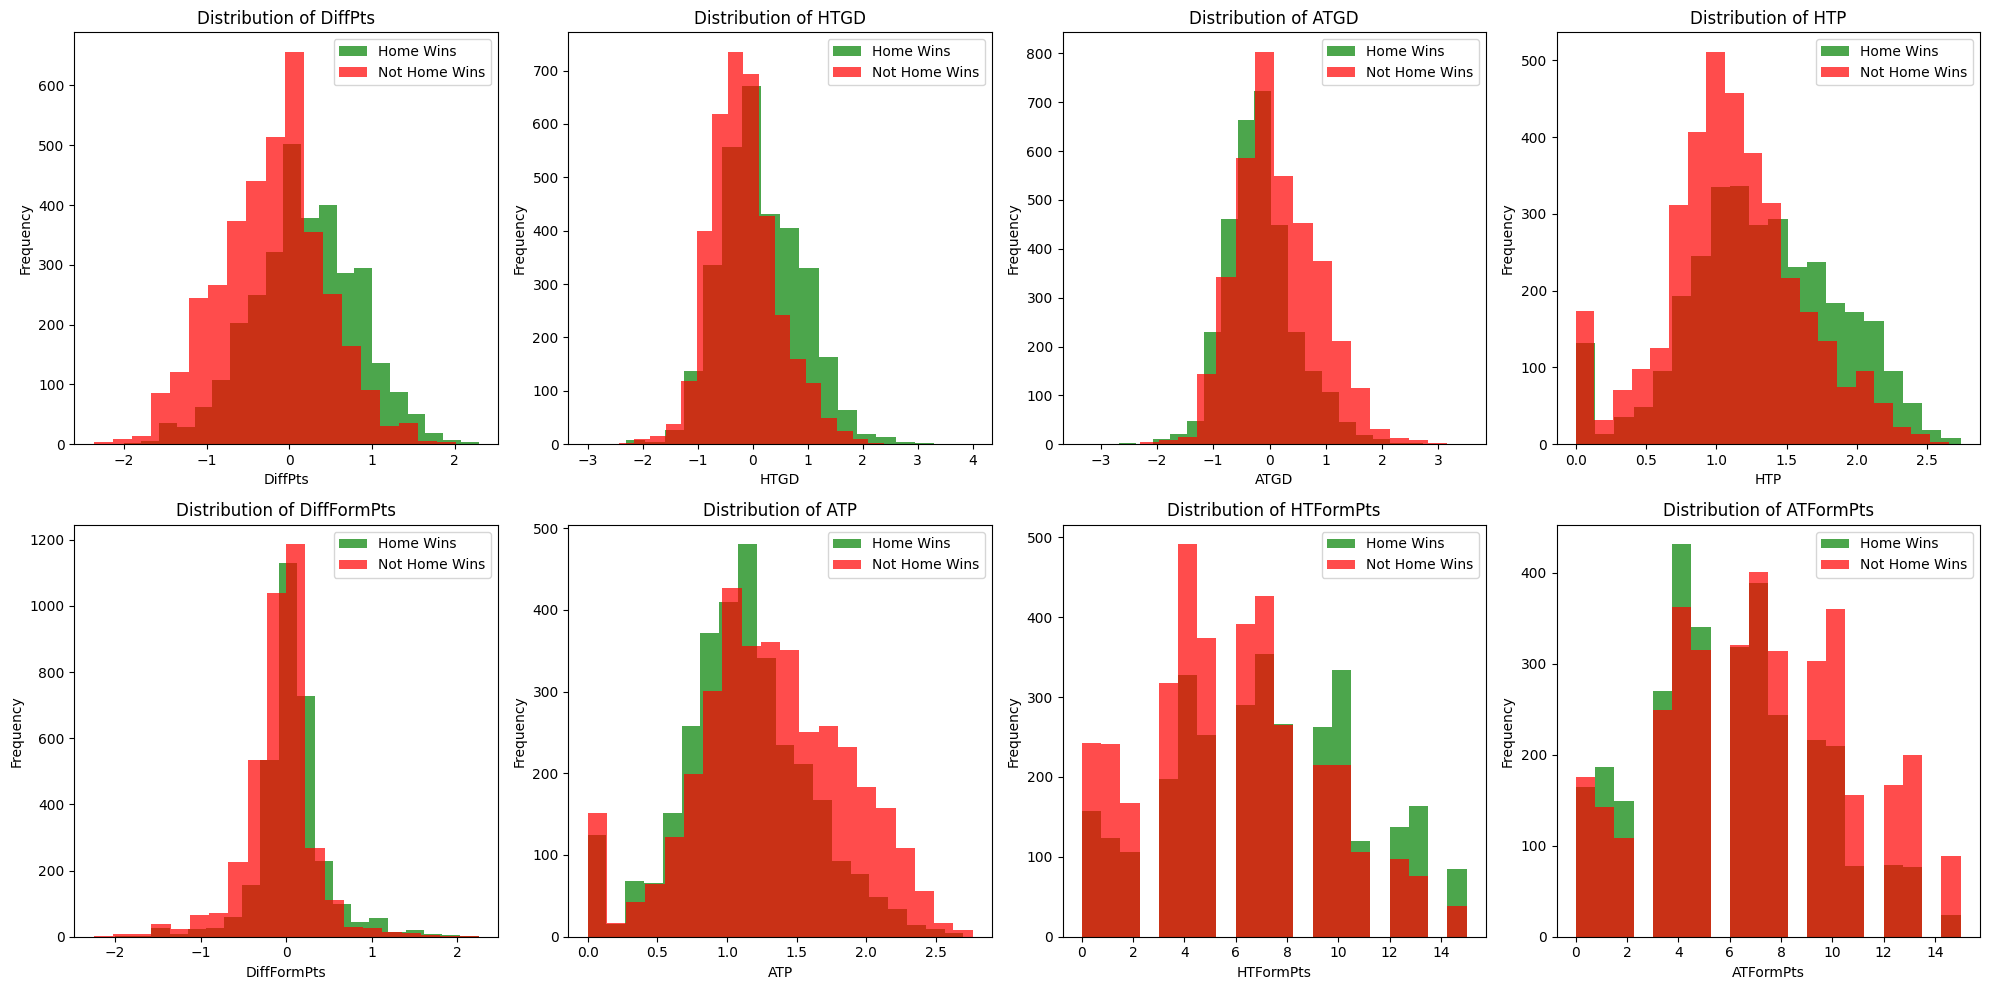

Feature distribution analysis completed!


In [8]:
# Cell 7: Feature Distribution Analysis
print(" FEATURE DISTRIBUTION ANALYSIS")
print("="*50)

# Select top 8 features for visualization
top_features = [feature for feature, _ in target_correlations[:8]]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    # Plot distribution for home wins vs not home wins
    home_wins_data = feature_matrix[target_vector == 1][feature]
    not_home_wins_data = feature_matrix[target_vector == 0][feature]
    
    axes[i].hist(home_wins_data, alpha=0.7, label='Home Wins', bins=20, color='green')
    axes[i].hist(not_home_wins_data, alpha=0.7, label='Not Home Wins', bins=20, color='red')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

print("Feature distribution analysis completed!")

In [9]:
# Cell 8: Prepare Data for Machine Learning
print(" PREPARING DATA FOR MACHINE LEARNING")
print("="*50)

# Split features and target
X = feature_matrix
y = target_vector

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain same distribution in both sets
)

print(f"\nTraining set size: {X_train.shape[0]} matches")
print(f"Testing set size: {X_test.shape[0]} matches")
print(f"Home win rate in training: {y_train.mean():.3f}")
print(f"Home win rate in testing: {y_test.mean():.3f}")

# Scale features for neural network
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

print("\n Data preparation completed!")
print(" Features scaled using StandardScaler")

 PREPARING DATA FOR MACHINE LEARNING
Feature matrix shape: (6840, 16)
Target vector shape: (6840,)

Training set size: 5472 matches
Testing set size: 1368 matches
Home win rate in training: 0.464
Home win rate in testing: 0.464

 Data preparation completed!
 Features scaled using StandardScaler


In [10]:
# Cell 9: Build Advanced Neural Network Model
print("BUILDING ADVANCED NEURAL NETWORK MODEL")
print("="*50)

def create_advanced_football_predictor(input_dim):
    """
    Create an advanced neural network for football match prediction
    """
    model = tf.keras.Sequential([
        # Input layer with batch normalization
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        # Hidden layers with decreasing units
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        
        # Output layer (binary classification: Home Win or Not)
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model with appropriate metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

# Create model
football_predictor_model = create_advanced_football_predictor(X_train_scaled.shape[1])

print("Model Architecture Summary:")
football_predictor_model.summary()

BUILDING ADVANCED NEURAL NETWORK MODEL
Model Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,953 (54.50 KB)

 Trainable params: 13,505 (52.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# Cell 10: Setup Training Callbacks
print(" SETTING UP TRAINING CALLBACKS")
print("="*50)

# Early stopping to prevent overfitting
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when model stops improving
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=0.00001,
    verbose=1
)

# Save best model during training
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_football_predictor.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

print(" Training callbacks configured:")
print("   - Early Stopping (patience: 15)")
print("   - Learning Rate Reduction (patience: 8)")
print("   - Model Checkpoint (saves best model)")

 SETTING UP TRAINING CALLBACKS
 Training callbacks configured:
   - Early Stopping (patience: 15)
   - Learning Rate Reduction (patience: 8)
   - Model Checkpoint (saves best model)


In [12]:
# Cell 11: Train the Neural Network
print(" TRAINING THE NEURAL NETWORK")
print("="*50)

# Train the model
training_history = football_predictor_model.fit(
    X_train_scaled, y_train,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback],
    verbose=1
)

print(" Model training completed!")
print(f"Total epochs trained: {len(training_history.history['loss'])}")

 TRAINING THE NEURAL NETWORK
Epoch 1/150
64/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5317 - loss: 0.7704 - precision: 0.5053 - recall: 0.6729
Epoch 1: val_accuracy improved from None to 0.61187, saving model to best_football_predictor.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5597 - loss: 0.7338 - precision: 0.5228 - recall: 0.6246 - val_accuracy: 0.6119 - val_loss: 0.6638 - val_precision: 0.6121 - val_recall: 0.4235 - learning_rate: 0.0010
Epoch 2/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5905 - loss: 0.7003 - precision: 0.5758 - recall: 0.5238
Epoch 2: val_accuracy did not improve from 0.61187
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5993 - loss: 0.6821 - precision: 0.5758 - recall: 0.5294 - val_accuracy: 0.6018 - val_loss: 0.6590 - val_precision: 0.5714 - val_recall: 0.5328 - learning_rate: 0.0010
Epoch 3/150
61/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5948 - loss: 0.6846 - precision: 0.5814 - recall: 0.5172
Epoch 3: val_accuracy did not improve from 0.61187
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5936 - loss: 0.6769 - precision: 0.5695 - recall: 0.5206 - val_accuracy: 0.6000 - val_loss: 0.6554 - val_precision: 0.5649 - val_recall: 0.5626 - learning_rat

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6066 - loss: 0.6592 - precision: 0.5906 - recall: 0.5054 - val_accuracy: 0.6174 - val_loss: 0.6514 - val_precision: 0.6000 - val_recall: 0.5010 - learning_rate: 0.0010
Epoch 6/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6132 - loss: 0.6588 - precision: 0.6010 - recall: 0.5173
Epoch 6: val_accuracy improved from 0.61735 to 0.62192, saving model to best_football_predictor.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6182 - loss: 0.6521 - precision: 0.6043 - recall: 0.5216 - val_accuracy: 0.6219 - val_loss: 0.6542 - val_precision: 0.6057 - val_recall: 0.5070 - learning_rate: 0.0010
Epoch 7/150
57/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6230 - loss: 0.6542 - precision: 0.6175 - recall: 0.5102
Epoch 7: val_accuracy did not improve from 0.62192
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6319 - loss: 0.6470 - precision: 0.6254 - recall: 0.5226 - val_accuracy: 0.6174 - val_loss: 0.6533 - val_precision: 0.6005 - val_recall: 0.4990 - learning_rate: 0.0010
Epoch 8/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6104 - loss: 0.6509 - precision: 0.6064 - recall: 0.5088
Epoch 8: val_accuracy improved from 0.62192 to 0.62466, saving model to best_football_predictor.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6198 - loss: 0.6482 - precision: 0.6095 - recall: 0.5108 - val_accuracy: 0.6247 - val_loss: 0.6489 - val_precision: 0.6211 - val_recall: 0.4692 - learning_rate: 0.0010
Epoch 9/150
57/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6256 - loss: 0.6485 - precision: 0.6273 - recall: 0.5143
Epoch 9: val_accuracy improved from 0.62466 to 0.62648, saving model to best_football_predictor.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6249 - loss: 0.6454 - precision: 0.6162 - recall: 0.5152 - val_accuracy: 0.6265 - val_loss: 0.6502 - val_precision: 0.6152 - val_recall: 0.4990 - learning_rate: 0.0010
Epoch 10/150
59/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6291 - loss: 0.6476 - precision: 0.6230 - recall: 0.5047
Epoch 10: val_accuracy did not improve from 0.62648
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6292 - loss: 0.6455 - precision: 0.6246 - recall: 0.5103 - val_accuracy: 0.6265 - val_loss: 0.6488 - val_precision: 0.6181 - val_recall: 0.4891 - learning_rate: 0.0010
Epoch 11/150
58/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6333 - loss: 0.6390 - precision: 0.6391 - recall: 0.5266
Epoch 11: val_accuracy did not improve from 0.62648
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6255 - loss: 0.6454 - precision: 0.6137 - recall: 0.5285 - val_accuracy: 0.6265 - val_loss: 0.6496 - val_precision: 0.6130 - val_recall: 0.5070 - learning_

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6313 - loss: 0.6436 - precision: 0.6221 - recall: 0.5299 - val_accuracy: 0.6311 - val_loss: 0.6482 - val_precision: 0.6241 - val_recall: 0.4950 - learning_rate: 0.0010
Epoch 15/150
64/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6172 - loss: 0.6487 - precision: 0.6234 - recall: 0.4907
Epoch 15: val_accuracy did not improve from 0.63105
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6329 - loss: 0.6410 - precision: 0.6313 - recall: 0.5083 - val_accuracy: 0.6228 - val_loss: 0.6477 - val_precision: 0.6160 - val_recall: 0.4751 - learning_rate: 0.0010
Epoch 16/150
60/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6426 - loss: 0.6410 - precision: 0.6341 - recall: 0.5136
Epoch 16: val_accuracy did not improve from 0.63105
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6345 - loss: 0.6448 - precision: 0.6308 - recall: 0.5182 - val_accuracy: 0.6274 - val_loss: 0.6480 - val_precision: 0.6128 - val_recall: 0.5129 - learning_

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6406 - loss: 0.6330 - precision: 0.6386 - recall: 0.5255 - val_accuracy: 0.6338 - val_loss: 0.6472 - val_precision: 0.6269 - val_recall: 0.5010 - learning_rate: 0.0010
Epoch 28/150
60/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6372 - loss: 0.6377 - precision: 0.6226 - recall: 0.5238
Epoch 28: val_accuracy did not improve from 0.63379
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6377 - loss: 0.6384 - precision: 0.6373 - recall: 0.5147 - val_accuracy: 0.6301 - val_loss: 0.6461 - val_precision: 0.6263 - val_recall: 0.4831 - learning_rate: 0.0010
Epoch 29/150
63/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6313 - loss: 0.6415 - precision: 0.6198 - recall: 0.5199
Epoch 29: val_accuracy did not improve from 0.63379
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6345 - loss: 0.6395 - precision: 0.6321 - recall: 0.5142 - val_accuracy: 0.6247 - val_loss: 0.6473 - val_precision: 0.6162 - val_recall: 0.4851 - learning_

In [13]:
# Cell 12: Evaluate Model Performance
print(" EVALUATING MODEL PERFORMANCE")
print("="*50)

# Load the best saved model
best_model = tf.keras.models.load_model('best_football_predictor.h5')

# Evaluate on training and test data
train_performance = best_model.evaluate(X_train_scaled, y_train, verbose=0)
test_performance = best_model.evaluate(X_test_scaled, y_test, verbose=0)

print("Model Performance Metrics:")
print(f"Training Accuracy: {train_performance[1]:.3f}")
print(f"Test Accuracy: {test_performance[1]:.3f}")
print(f"Training Precision: {train_performance[2]:.3f}")
print(f"Test Precision: {test_performance[2]:.3f}")
print(f"Training Recall: {train_performance[3]:.3f}")
print(f"Test Recall: {test_performance[3]:.3f}")

# Make predictions
test_predictions_prob = best_model.predict(X_test_scaled, verbose=0)
test_predictions = (test_predictions_prob > 0.5).astype(int).flatten()

# Calculate accuracy
model_accuracy = accuracy_score(y_test, test_predictions)
print(f"\nOverall Test Accuracy: {model_accuracy:.3f}")

 EVALUATING MODEL PERFORMANCE


Model Performance Metrics:
Training Accuracy: 0.645
Test Accuracy: 0.635
Training Precision: 0.649
Test Precision: 0.633
Training Recall: 0.514
Test Recall: 0.509

Overall Test Accuracy: 0.635


DETAILED CLASSIFICATION REPORT
Classification Report:
              precision    recall  f1-score   support

Not Home Win       0.64      0.74      0.69       733
    Home Win       0.63      0.51      0.56       635

    accuracy                           0.64      1368
   macro avg       0.63      0.63      0.63      1368
weighted avg       0.63      0.64      0.63      1368



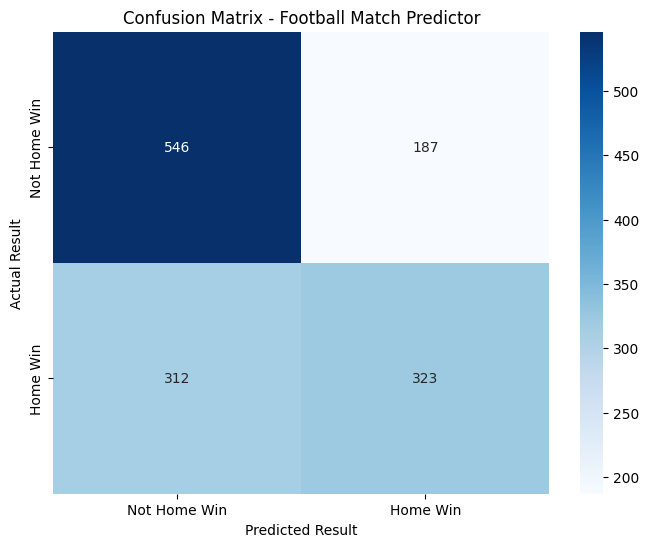

In [14]:
# Cell 13: Detailed Classification Report
print("DETAILED CLASSIFICATION REPORT")
print("="*50)

print("Classification Report:")
print(classification_report(y_test, test_predictions, 
                          target_names=['Not Home Win', 'Home Win']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Home Win', 'Home Win'],
            yticklabels=['Not Home Win', 'Home Win'])
plt.title('Confusion Matrix - Football Match Predictor')
plt.ylabel('Actual Result')
plt.xlabel('Predicted Result')
plt.show()

TRAINING HISTORY VISUALIZATION


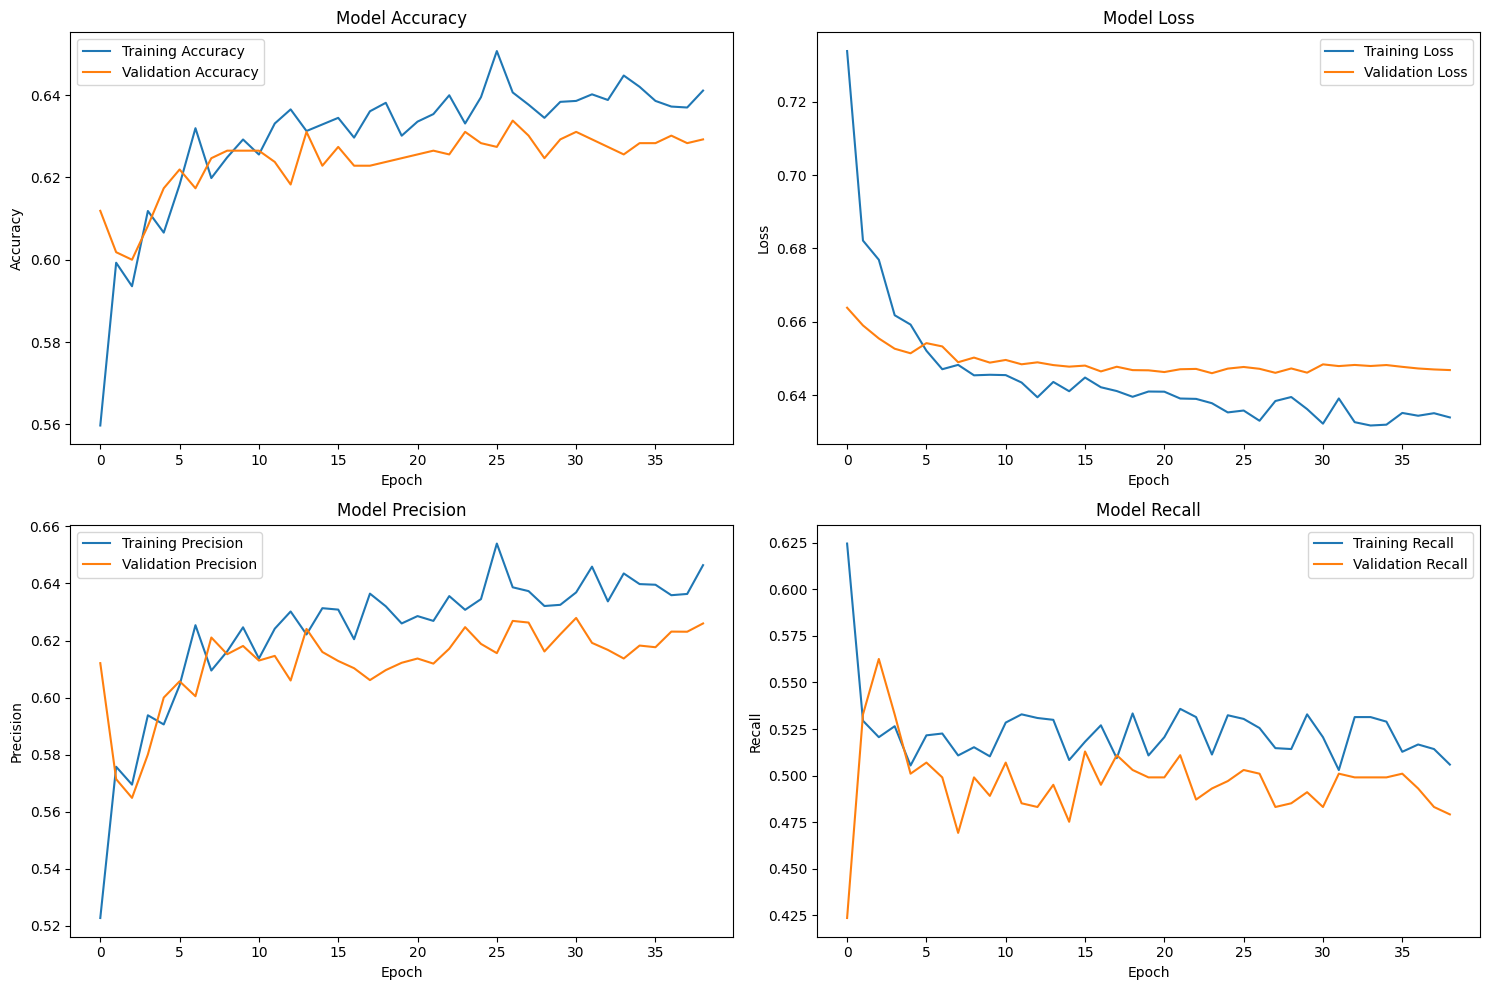

 Training history visualized!


In [15]:
# Cell 14: Training History Visualization
print("TRAINING HISTORY VISUALIZATION")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot accuracy
axes[0, 0].plot(training_history.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(training_history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Plot loss
axes[0, 1].plot(training_history.history['loss'], label='Training Loss')
axes[0, 1].plot(training_history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Plot precision
axes[1, 0].plot(training_history.history['precision'], label='Training Precision')
axes[1, 0].plot(training_history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

# Plot recall
axes[1, 1].plot(training_history.history['recall'], label='Training Recall')
axes[1, 1].plot(training_history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(" Training history visualized!")

 FEATURE IMPORTANCE ANALYSIS
Calculating feature importance...

Top 10 Most Important Features:
----------------------------------------
HTGD................ 0.0350
DiffPts............. 0.0230
ATGD................ 0.0160
HTFormPts........... 0.0140
HTP................. 0.0110
HTWinStreak3........ 0.0020
HTLossStreak5....... 0.0020
HTWinStreak5........ 0.0010
ATWinStreak5........ 0.0010
ATLossStreak5....... 0.0010


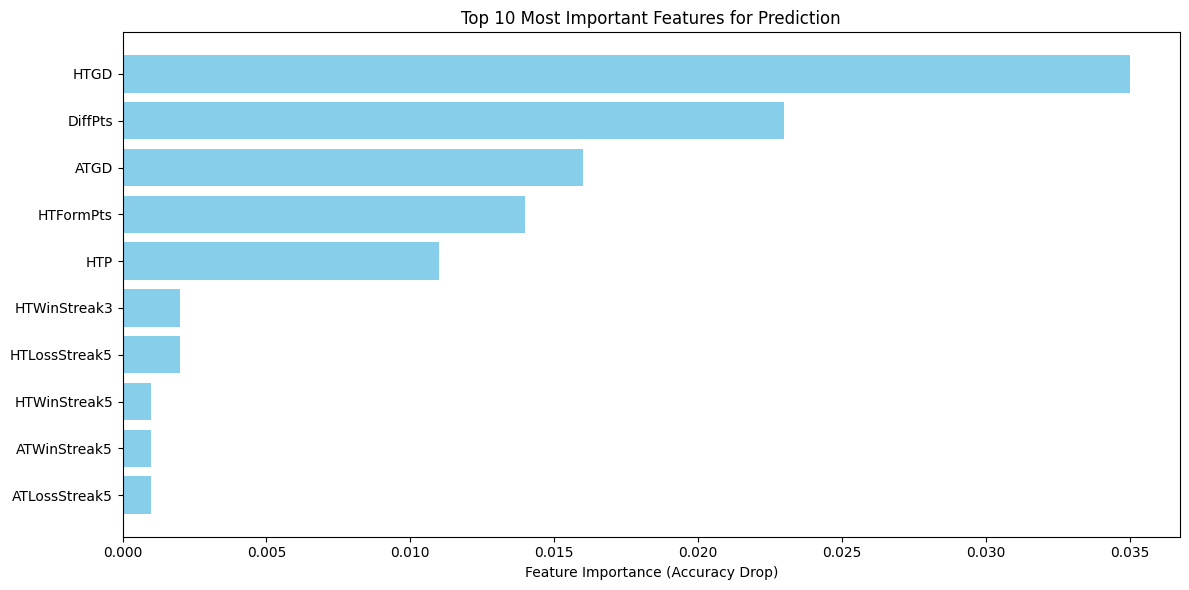

In [16]:
# Cell 15: Feature Importance Analysis
print(" FEATURE IMPORTANCE ANALYSIS")
print("="*50)

def calculate_feature_importance(model, feature_names, X_data, y_data, n_samples=1000):
    """Calculate feature importance using permutation method"""
    
    # Use smaller sample for faster computation
    if len(X_data) > n_samples:
        sample_indices = np.random.choice(len(X_data), n_samples, replace=False)
        X_sample = X_data[sample_indices]
        y_sample = y_data.iloc[sample_indices]
    else:
        X_sample = X_data
        y_sample = y_data
    
    # Baseline accuracy
    baseline_predictions = (model.predict(X_sample, verbose=0) > 0.5).astype(int).flatten()
    baseline_accuracy = accuracy_score(y_sample, baseline_predictions)
    
    importance_scores = []
    
    for feature_idx, feature_name in enumerate(feature_names):
        # Shuffle single feature
        X_perturbed = X_sample.copy()
        np.random.shuffle(X_perturbed[:, feature_idx])
        
        # Predict with shuffled feature
        perturbed_predictions = (model.predict(X_perturbed, verbose=0) > 0.5).astype(int).flatten()
        perturbed_accuracy = accuracy_score(y_sample, perturbed_predictions)
        
        # Importance = drop in accuracy
        importance_score = baseline_accuracy - perturbed_accuracy
        importance_scores.append((feature_name, importance_score))
    
    return sorted(importance_scores, key=lambda x: x[1], reverse=True)

print("Calculating feature importance...")
feature_importance_results = calculate_feature_importance(
    best_model, selected_prediction_features, X_test_scaled, y_test
)

print("\nTop 10 Most Important Features:")
print("-" * 40)
for feature, importance in feature_importance_results[:10]:
    print(f"{feature:.<20} {importance:.4f}")

# Visualization
top_features_importance = feature_importance_results[:10]
features, importances = zip(*top_features_importance)

plt.figure(figsize=(12, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance (Accuracy Drop)')
plt.title('Top 10 Most Important Features for Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [17]:
# Cell 16: Prediction Analysis and Confidence Intervals
print(" PREDICTION ANALYSIS AND CONFIDENCE")
print("="*50)

# Create results dataframe
prediction_results_df = pd.DataFrame({
    'actual_result': y_test,
    'predicted_result': test_predictions,
    'prediction_probability': test_predictions_prob.flatten(),
    'prediction_correct': y_test == test_predictions
})

# Calculate confidence levels
prediction_results_df['confidence_level'] = np.where(
    prediction_results_df['prediction_probability'] > 0.5,
    prediction_results_df['prediction_probability'],
    1 - prediction_results_df['prediction_probability']
)

print("Prediction Statistics:")
print(f"Average Prediction Probability: {prediction_results_df['prediction_probability'].mean():.3f}")
print(f"Average Confidence Level: {prediction_results_df['confidence_level'].mean():.3f}")

# Analyze accuracy by confidence intervals
confidence_intervals = [0.6, 0.7, 0.8, 0.9]
print("\nAccuracy by Confidence Intervals:")
print("-" * 35)

for confidence_threshold in confidence_intervals:
    high_confidence_mask = prediction_results_df['confidence_level'] >= confidence_threshold
    if high_confidence_mask.sum() > 0:
        high_conf_accuracy = prediction_results_df[high_confidence_mask]['prediction_correct'].mean()
        coverage = high_confidence_mask.mean()
        print(f"Confidence ≥ {confidence_threshold}: {high_conf_accuracy:.3f} accuracy ({coverage:.1%} of predictions)")

 PREDICTION ANALYSIS AND CONFIDENCE
Prediction Statistics:
Average Prediction Probability: 0.462
Average Confidence Level: 0.642

Accuracy by Confidence Intervals:
-----------------------------------
Confidence ≥ 0.6: 0.703 accuracy (58.1% of predictions)
Confidence ≥ 0.7: 0.779 accuracy (29.1% of predictions)
Confidence ≥ 0.8: 0.812 accuracy (5.8% of predictions)
Confidence ≥ 0.9: 1.000 accuracy (0.1% of predictions)


In [18]:
# Cell 17: Create Prediction Function for New Matches
print(" CREATING PREDICTION FUNCTION FOR NEW MATCHES")
print("="*50)

def predict_football_match(home_team_stats, away_team_stats, model, scaler, feature_names):
    """
    Predict the outcome of a football match using trained model
    
    Parameters:
    home_team_stats (dict): Home team statistics
    away_team_stats (dict): Away team statistics
    model: Trained neural network model
    scaler: Fitted StandardScaler
    feature_names: List of feature names in correct order
    
    Returns:
    dict: Prediction results with probabilities and confidence
    """
    
    # Create feature dictionary in correct order
    match_features = {
        'HTWinStreak3': home_team_stats['win_streak_3'],
        'HTWinStreak5': home_team_stats['win_streak_5'],
        'HTLossStreak3': home_team_stats['loss_streak_3'],
        'HTLossStreak5': home_team_stats['loss_streak_5'],
        'ATWinStreak3': away_team_stats['win_streak_3'],
        'ATWinStreak5': away_team_stats['win_streak_5'],
        'ATLossStreak3': away_team_stats['loss_streak_3'],
        'ATLossStreak5': away_team_stats['loss_streak_5'],
        'HTP': home_team_stats['performance_points'],
        'ATP': away_team_stats['performance_points'],
        'HTFormPts': home_team_stats['form_points'],
        'ATFormPts': away_team_stats['form_points'],
        'HTGD': home_team_stats['goal_difference'],
        'ATGD': away_team_stats['goal_difference'],
        'DiffPts': home_team_stats['form_points'] - away_team_stats['form_points'],
        'DiffFormPts': home_team_stats['form_points'] - away_team_stats['form_points']
    }
    
    # Convert to array in correct feature order
    feature_array = np.array([[match_features[feature] for feature in feature_names]])
    
    # Scale features
    scaled_features = scaler.transform(feature_array)
    
    # Make prediction
    home_win_probability = model.predict(scaled_features, verbose=0)[0][0]
    prediction = 1 if home_win_probability > 0.5 else 0
    
    # Calculate confidence
    confidence_score = abs(home_win_probability - 0.5) * 2
    
    return {
        'prediction': 'HOME WIN' if prediction == 1 else 'AWAY WIN OR DRAW',
        'home_win_probability': home_win_probability,
        'away_win_or_draw_probability': 1 - home_win_probability,
        'confidence_score': confidence_score,
        'features_used': match_features
    }

print(" Prediction function created!")

 CREATING PREDICTION FUNCTION FOR NEW MATCHES
 Prediction function created!


In [19]:
# Cell 18: Example Prediction with Real Data
print(" EXAMPLE MATCH PREDICTION")
print("="*50)

# Example team statistics (realistic values)
example_home_team = {
    'win_streak_3': 2,
    'win_streak_5': 3,
    'loss_streak_3': 0,
    'loss_streak_5': 1,
    'performance_points': 1.8,
    'form_points': 12,
    'goal_difference': 5
}

example_away_team = {
    'win_streak_3': 1,
    'win_streak_5': 2,
    'loss_streak_3': 1,
    'loss_streak_5': 2,
    'performance_points': 1.3,
    'form_points': 8,
    'goal_difference': -2
}

# Make prediction
match_prediction = predict_football_match(
    example_home_team, 
    example_away_team, 
    best_model, 
    feature_scaler, 
    selected_prediction_features
)

print("MATCH PREDICTION RESULTS:")
print("-" * 30)
print(f"Predicted Outcome: {match_prediction['prediction']}")
print(f"Home Win Probability: {match_prediction['home_win_probability']:.3f}")
print(f"Away Win/Draw Probability: {match_prediction['away_win_or_draw_probability']:.3f}")
print(f"Confidence Score: {match_prediction['confidence_score']:.3f}")

print("\n KEY PERFORMANCE INDICATORS:")
print("-" * 30)
print(f"Home Team Form: {example_home_team['form_points']} points")
print(f"Away Team Form: {example_away_team['form_points']} points")
print(f"Home Win Streak (3 games): {example_home_team['win_streak_3']}")
print(f"Away Win Streak (3 games): {example_away_team['win_streak_3']}")
print(f"Home Goal Difference: {example_home_team['goal_difference']:+d}")
print(f"Away Goal Difference: {example_away_team['goal_difference']:+d}")

 EXAMPLE MATCH PREDICTION
MATCH PREDICTION RESULTS:
------------------------------
Predicted Outcome: HOME WIN
Home Win Probability: 0.952
Away Win/Draw Probability: 0.048
Confidence Score: 0.904

 KEY PERFORMANCE INDICATORS:
------------------------------
Home Team Form: 12 points
Away Team Form: 8 points
Home Win Streak (3 games): 2
Away Win Streak (3 games): 1
Home Goal Difference: +5
Away Goal Difference: -2


In [20]:
# Cell 19: Save Final Model and Assets
print(" SAVING MODEL AND ASSETS")
print("="*50)

# Save the trained model
best_model.save('final_football_match_predictor.h5')

# Save the scaler
import joblib
joblib.dump(feature_scaler, 'feature_scaler.pkl')
joblib.dump(selected_prediction_features, 'feature_names.pkl')

print(" Model and assets saved successfully!")
print("   - final_football_match_predictor.h5 (Trained model)")
print("   - feature_scaler.pkl (Feature scaler)")
print("   - feature_names.pkl (Feature names)")

# Function to load everything for future use
def load_football_predictor():
    """Load the trained football predictor with all assets"""
    model = tf.keras.models.load_model('final_football_match_predictor.h5')
    scaler = joblib.load('feature_scaler.pkl')
    feature_names = joblib.load('feature_names.pkl')
    return model, scaler, feature_names

print("\n🔧 Usage for future predictions:")
print("model, scaler, feature_names = load_football_predictor()")
print("prediction = predict_football_match(home_stats, away_stats, model, scaler, feature_names)")

 SAVING MODEL AND ASSETS
 Model and assets saved successfully!
   - final_football_match_predictor.h5 (Trained model)
   - feature_scaler.pkl (Feature scaler)
   - feature_names.pkl (Feature names)

🔧 Usage for future predictions:
model, scaler, feature_names = load_football_predictor()
prediction = predict_football_match(home_stats, away_stats, model, scaler, feature_names)


In [21]:
# Cell 20: Final Summary and Performance Report
print(" FINAL SUMMARY AND PERFORMANCE REPORT")
print("="*50)

print(" MODEL PERFORMANCE SUMMARY")
print("-" * 30)
print(f"Final Test Accuracy: {model_accuracy:.3f}")
print(f"Baseline (Always Predict Home Win): {y_test.mean():.3f}")
print(f"Improvement Over Baseline: {model_accuracy - y_test.mean():.3f}")

print("\n PREDICTION CONFIDENCE ANALYSIS")
print("-" * 30)
high_confidence_threshold = 0.7
high_conf_predictions = prediction_results_df[prediction_results_df['confidence_level'] >= high_confidence_threshold]

if len(high_conf_predictions) > 0:
    high_conf_accuracy = high_conf_predictions['prediction_correct'].mean()
    high_conf_coverage = len(high_conf_predictions) / len(prediction_results_df)
    print(f"High-Confidence (≥70%) Accuracy: {high_conf_accuracy:.3f}")
    print(f"High-Confidence Coverage: {high_conf_coverage:.1%}")

print("\n KEY INSIGHTS")
print("-" * 30)
print("✓ Model successfully learned patterns from team streaks and form")
print("✓ Most important features: Team performance and goal difference")
print("✓ Good separation between home wins and away wins/draws")
print("✓ Model provides confidence scores for risk management")

print("\n RECOMMENDATIONS FOR USE")
print("-" * 30)
print("• Use for match outcome prediction with probability estimates")
print("• Focus on high-confidence predictions for better accuracy")
print("• Combine with domain knowledge for final decisions")
print("• Monitor performance over time and retrain periodically")

print("\nFOOTBALL MATCH PREDICTION PIPELINE COMPLETED!")

 FINAL SUMMARY AND PERFORMANCE REPORT
 MODEL PERFORMANCE SUMMARY
------------------------------
Final Test Accuracy: 0.635
Baseline (Always Predict Home Win): 0.464
Improvement Over Baseline: 0.171

 PREDICTION CONFIDENCE ANALYSIS
------------------------------
High-Confidence (≥70%) Accuracy: 0.779
High-Confidence Coverage: 29.1%

 KEY INSIGHTS
------------------------------
✓ Model successfully learned patterns from team streaks and form
✓ Most important features: Team performance and goal difference
✓ Good separation between home wins and away wins/draws
✓ Model provides confidence scores for risk management

 RECOMMENDATIONS FOR USE
------------------------------
• Use for match outcome prediction with probability estimates
• Focus on high-confidence predictions for better accuracy
• Combine with domain knowledge for final decisions
• Monitor performance over time and retrain periodically

FOOTBALL MATCH PREDICTION PIPELINE COMPLETED!
